The worflow:

for each frame:
    mask cars appearing on frame at instant t (maybe use dilation)
    extract edges (evaluate this two changing the order)
    get Lines filtered by certain range of angles (get horizontal and vertical, but separately) (maybe explore this for lane markings)
Once lines are saved:
        get histogram of orientations
        get histogram of lengths
        remove outliers
map all endpoints of lines to pre defined lengths
use them to train a MLP.
Test
    

In [1]:
import cv2
import numpy as np
import torchvision.transforms as T

from sklearn.neighbors import KernelDensity
from objectDetection import *
from carMasking import *
from imgFeatureUtils import *

%matplotlib inline

forExt = DLForegroundExtractor(512)
videoPath = "/home/hector/speed/speed_DS/v1.mp4"

In [2]:
yolo = objectDetector((512,512),
                       weightPath="yolov3/weights/yolov3.weights",
                       modelDef="yolov3/config/yolov3.cfg")
viz = objectVisualizer(classPath="yolov3/data/coco.names")
tools = objectFocusTools((512,512),yolo)
linesDataset = []
cap = cv2.VideoCapture("/home/hector/speed/speed_DS/v5.avi")
lineSetH = []
lineSetV = []
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    frame = cv2.resize(frame, (512,512))
    grayFrame = convertImg2Grayscale(frame)
#(-60,-40) vertical, (0,20) horizontal 
    linesV, edgeMap = tools.getObjectLinesAtFrame(frame,grayFrame,(-60,-40))
    linesH, edgeMap = tools.getObjectLinesAtFrame(frame, grayFrame, (0,20))
    lineDist = getLinesEuclideanDist(lines)
    thetas = getLinesThetas(lines)
    print(lines)
    lineSetH.append(linesH)
    lineSetV.append(linesV)
    empty = np.zeros((edgeMap.shape[0],edgeMap.shape[1],3))
    empty[:,:,0] = edgeMap
    #frameObjs = viz.drawBoxes(frame,detections)
    linesImg = drawLinesOnImg(empty, lines)
    cv2.imshow('Frame',linesImg)
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
  else: 
    break
#print("final feature set")
#print(featureSet)
cap.release()
cv2.destroyAllWindows()
lineSet = flatten(lineSet)

 ((285, 411), (298, 392)), ((270, 382), (282, 367)), ((273, 438), (283, 423)), ((269, 418), (280, 403)), ((270, 388), (285, 367)), ((286, 388), (302, 371)), ((269, 391), (279, 376)), ((282, 417), (298, 391)), ((258, 438), (267, 423)), ((305, 235), (319, 218))]
[((274, 410), (296, 379)), ((286, 392), (297, 376)), ((284, 389), (297, 372)), ((277, 376), (290, 361)), ((249, 375), (263, 354)), ((294, 396), (304, 381)), ((281, 415), (304, 382)), ((250, 374), (264, 353)), ((238, 394), (247, 379)), ((284, 390), (300, 370)), ((240, 423), (252, 407)), ((274, 376), (289, 355)), ((321, 163), (336, 149)), ((322, 244), (338, 228))]
[((279, 394), (308, 359)), ((288, 382), (299, 367)), ((281, 399), (302, 368)), ((289, 402), (305, 380)), ((275, 407), (290, 385)), ((278, 378), (289, 359)), ((254, 368), (268, 348)), ((276, 373), (292, 350)), ((269, 422), (279, 406)), ((253, 368), (267, 348)), ((276, 369), (287, 354)), ((300, 391), (310, 374)), ((396, 200), (408, 183)), ((324, 242), (339, 227)), ((324, 24

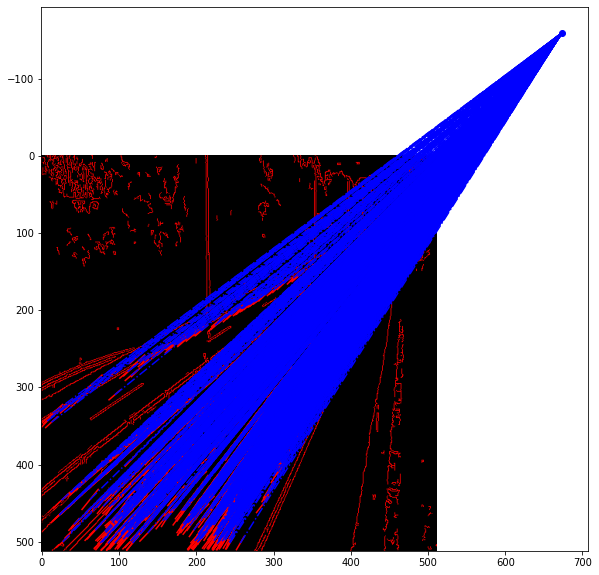

In [7]:
from projectiveGeometry import compute_edgelets, ransac_vanishing_point, vis_model, reestimate_model
lineSet = np.expand_dims(lineSet, axis=0)[0]
edgelets = compute_edgelets(lineSet)
vp1 = ransac_vanishing_point(edgelets, num_ransac_iter=5000, 
                             threshold_inlier=5)
vis_model(empty, lineSet, vp1)

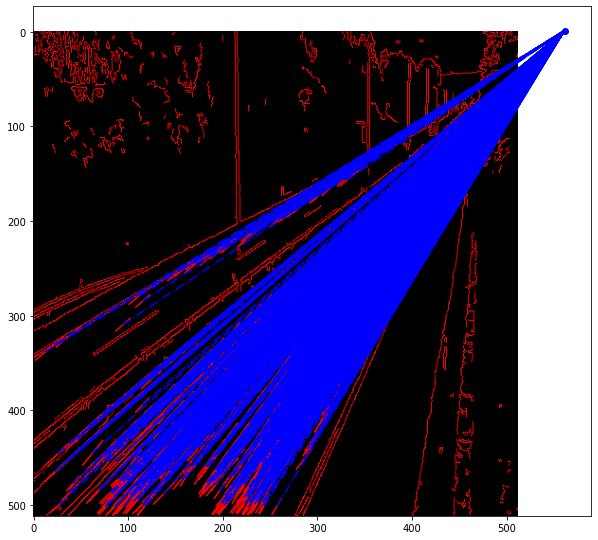

In [6]:
vp1p = reestimate_model(vp1, edgelets, threshold_reestimate=1)
vis_model(empty, lineSet, vp1p)